In [1]:
import pandas
import pickle
import matplotlib.pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import PCA

from core.dataHandler import DataHandler

ModuleNotFoundError: No module named 'core.dataHandler'

In [5]:
#reading data from db
data_handler = DataHandler
engine = data_handler.db_connect(db_url = "mysql+pymysql://root:secret@db:3306/my_db")

%reload_ext sql
%sql mysql+pymysql://root:secret@db:3306/my_db
dataframe = data_handler.get_data_from_db(query="SELECT * FROM TRANSACTION_DATA", con=engine)
dataframe.tail(5)

Connected:
 test_table


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [6]:
# Preparing dataset
features = dataframe.columns.to_list()
features.remove('Class')
X = dataframe[features]
y = dataframe['Class']

# Preprocessing step
X= preprocessing.StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5 ,random_state=1)


In [7]:
#pca plot, to see data 
pca = PCA(n_components=2)
pca.fit(X)
X = pandas.DataFrame(pca.transform(X))
X.head(5)

,0,1
0,0.423254,-2.518050
1,-0.395480,-2.091109
2,1.864221,-2.535496
3,0.310453,-1.778424
4,-0.001905,-1.470318


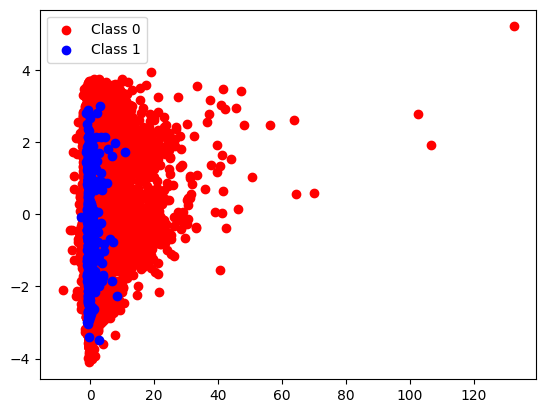

In [8]:
plt.scatter(X[y==0][0], X[y==0][1], label='Class 0', c='red')
plt.scatter(X[y==1][0], X[y==1][1], label='Class 1', c='blue')
plt.legend()
plt.show()

In [6]:
# Model definition
ensemble_tree = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3))
ensemble_tree_param = {'n_estimators':[20,50,100,300], 'learning_rate':[0.5,1,1.5]}


In [9]:
#Fitting model
grid_search_et = GridSearchCV(ensemble_tree, ensemble_tree_param, cv = 5, n_jobs=-1)
grid_search_et.fit(X_train, y_train.ravel())
print(grid_search_et.best_params_)
best_estimator_et = grid_search_et.best_estimator_

{'learning_rate': 1, 'n_estimators': 300}


In [10]:
# Saving classifier
with open('/usr/src/app/models/ensenble_tree.pkl','wb') as file:
  pickle.dump(best_estimator_et,file)

In [10]:
with open('/usr/src/app/models/ensenble_tree.pkl','rb') as file:
  classifier = pickle.load(file)

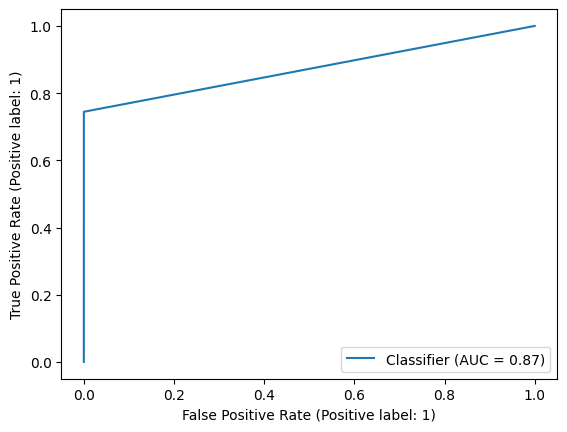

In [11]:
y_pred = classifier.predict(X_test)
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

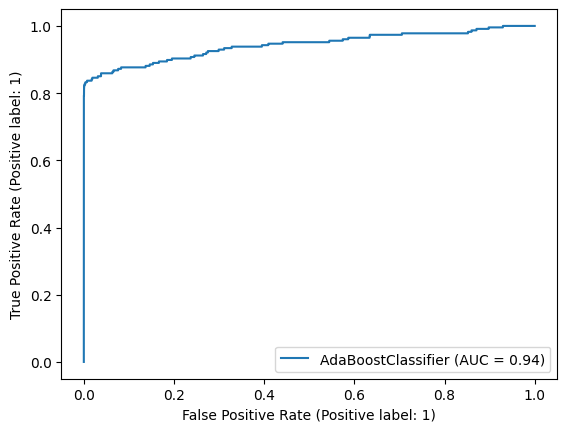

In [12]:
svc_disp = RocCurveDisplay.from_estimator(classifier, X_test, y_test)
plt.show()

In [13]:
f1_score(y_test.ravel(),y_pred)

0.832512315270936